# Introduction to Image Processing

author: Thomas Haslwanter, date: Dec-2019

## Getting Ready

Most of the software typically used for image processing, like *scipy*, *scikit-image*, *PIL*,  already comes installed with the major Python distributions.

*[OpenCV](http://www.opencv.org/)*, however, (which is a terrific program but not necessaritly required for this Notebook) often has to be installed by hand:

- On Windows machines, it is best to download the corresponding compiled *OpenCV*-package from [Christoph Gohlke](http://www.lfd.uci.edu/~gohlke/pythonlibs/) to your machine, and install it with *pip install [package]*.
- On Linux machines (and also on OSC) you should use *Anaconda*, and install *OpenCV* with

    conda install -c menpo opencv3


**Note:** the *OpenCV*-version of Christoph Gohlke does not contain all modules. Especially, the module [bioinspired](http://docs.opencv.org/3.0-beta/modules/bioinspired/doc/bioinspired.html) - which is a simulation of the retina - is not included. The easiest way to get this one to run on a Windows machine is to use *Anaconda*, and install *OpenCV* as described above.

## Data Representation

Images are typically not represented as 64-bit float numbers. Instead, to save space, typically 8-bit unsigned integers are used, giving us 256 gray-levels. However, watch out when working with unsigned integers:

In [58]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [59]:
# Watch out for overflow when working with unsigned integers!!
x = np.arange(10, dtype=np.uint8)
print(x+250)

[250 251 252 253 254 255   0   1   2   3]


### Where is up?

<img src="data\images\WhichWayUp.png" style="width: 600px;" align="left"/>

We are used to representing 2d maps with x/y coordinates, the first denoting horixontal, from left to right, and the second denoting vertical, from down to up.

However, when we index matrices, the first index denotes the rows, from top to bottom; and the second index the columns, from left to right:

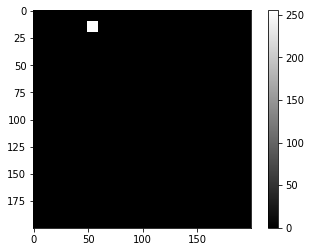

In [60]:
data = np.zeros((200,200), dtype=np.uint8)
data[10:20, 50:60]=255
plt.imshow(data)
plt.colorbar()
plt.gray()

#### Challenging orientations when using "ginput"

In [61]:
# Plot this into an external window, so that interactive selection is possible:
%matplotlib qt5

[[ 197. 1000.]]


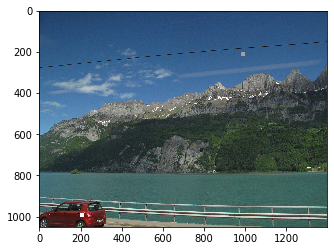

In [62]:
in_file = r'data\images\Waalensee.jpg'
img = plt.imread(in_file)
plt.imshow(img)
selected = np.round(np.array(plt.ginput(1)))
print(selected)

img_adjusted = img.copy()
img_adjusted[200:220, 980:1000] = 160 # gray
img_adjusted[980:1000, 200:220] = 255 # white
plt.imshow(img_adjusted)

In [63]:
# Back to inline images
%matplotlib inline

### Color representations

#### With Colormaps

gray() sets the colormap to "gray". Type help(colormaps) and CTRL+ENTER for more information.

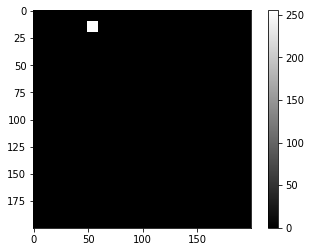

In [64]:
plt.gray()
plt.imshow(data)
plt.colorbar()
# in Matlab: imagesc()

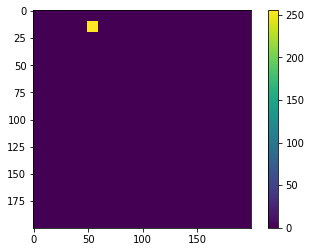

In [65]:
plt.viridis()
plt.imshow(data)
plt.colorbar()

#### As RGB (Red-Green-Blue)
Images which are represented in full color require a *red*, *green*, and *blue* (=RGB) channel, stacked up in a 3D-array:

(200, 200, 3)

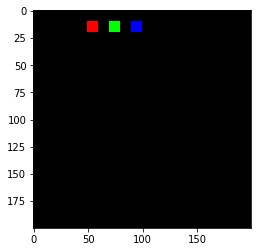

In [66]:
data_c = np.zeros((200,200,3), dtype=np.uint8)
data_c[10:20, 50:60, 0] = 255
data_c[10:20, 70:80, 1] = 255
data_c[10:20, 90:100, 2] = 255
plt.imshow(data_c)
data_c.shape

## Simple Image Manipulations

$R = \sqrt{x^2 + y^2}$

Note that you can use boolean expressions to address areas with specific properties in the image.

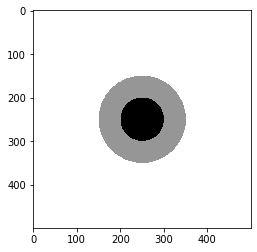

In [67]:
myrange = np.arange(-250,250)
X,Y = np.meshgrid(myrange, myrange)
Z = np.zeros(X.shape)

# Iris & pupil
R = np.sqrt(X**2+Y**2)   # in Matlab: replace "**" with ".^"
Z[R>50]=150
Z[R>100] = 255
plt.gray()
plt.imshow(Z)

The only tricky thing in the next step: I use "int32" to convert the result to integer (we can only set individual points), and use "250+..." to shift things into th middle of our plot.

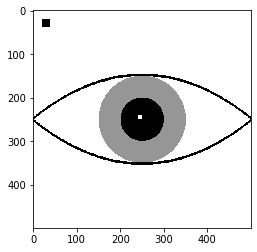

In [68]:
# Eyelids
polyPars = np.polyfit([-250, 0, 250], [0, 100, 0], 2)
x = np.arange(-250,250)
y = np.int32(np.polyval(polyPars, x))

lidThickness = 6
for ii in range(lidThickness):
    Z[ 250 + y+ii, 250 + x] = 1
    Z[ 250 - y-ii, 250 + x] = 1

# Add a few beauty spots
Z[20:40, 20:40] = 0
Z[240:250, 240:250] = 255
plt.imshow(Z)

### Saving a Figure

We can save the figure to PNG, JPEG, and other formats.

**Warning:** compressed image formats, e.g. JPEG, discard information by throwing away image details. Therefore they are not recommended for storing processed image data.

In [69]:
# Save the figure
print('Z has the shape {0}'.format(Z.shape))
outFile = 'test.png'
plt.imsave(outFile, Z)

Z has the shape (500, 500)


### Loading a Color Image

In [70]:
# Load the data again
# The 4th channel is used to indicate the alpha-transparency.

data = plt.imread(outFile)
print('"data" has the shape {0}'.format(data.shape))

"data" has the shape (500, 500, 4)


In [71]:
%matplotlib inline

## Data Filtering

For working with images, a number of different resources exist:

- [ndimage](http://docs.scipy.org/doc/scipy/reference/ndimage.html): SciPy functions for n-dimensional image processing
- [PIL](http://pillow.readthedocs.org/en/latest/index.html): the Python Image Library (now developed under the name "Pillow"). simple routines to manipulate images: resize, color conversions, simple filtering. Object oriented.
- [scikit-image](http://scikit-image.org/): a very "pythonic" collection of algorithms for image processing
- [opencv](http://opencv.org/): an open source image processing library written in C/C++, and designed for computational efficiency and with a strong focus on real-time applications.

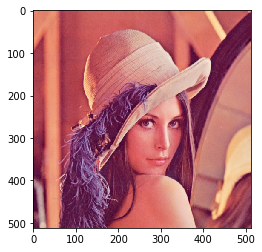

In [72]:
inFile = r'data\images\lena.jpg'
img = plt.imread(inFile)

# If you want the politically correct image,use
#from skimage.data import astronaut
#img = astronaut()
plt.imshow(img)
plt.show()

### Conversiont to Grayscale

When we apply a linear filter to a 2D image, we have to specify on which colorplane it is supposed to act. So the first step is often to convert an image to grayscale.

#### By Hand ...

One way to do this is by hand, using values that correspond to natural human vision. (Remember, we have more green than red receptors in the retina, and more red receptors than blue ones.)

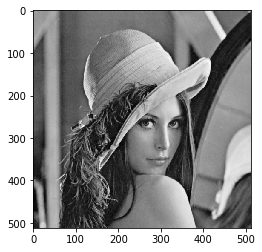

In [73]:
img_g = img.dot([0.2125, 0.7154, 0.0721]).astype(np.uint8)
plt.imshow(img_g)
plt.gray()

#### ..., or by using scikit-image (skimage) ...
The same conversion can be performed with the *scikit-image(skimage)*:

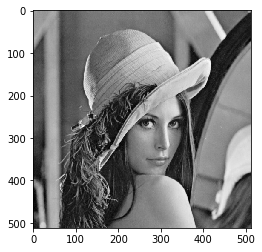

In [74]:
from skimage.color import rgb2gray
img_g_float = rgb2gray(img)
plt.imshow(img_g_float)

#### ..., by using the Python Image Library (PIL)

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=L size=512x512 at 0x1E5145E4CC8>


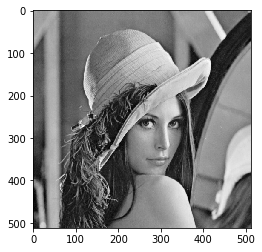

In [75]:
import PIL
pil_img = PIL.Image.fromarray(img)
pil_g = pil_img.convert('L')
plt.imshow(pil_g)

# Note the data-types: PIL provides a PIL-image!
print(type(img))
print(pil_g)

### Linear Filters - I: blurring

An [introduction to image filtereing is given in the wikibook on Sensory Systems](https://en.wikibooks.org/wiki/Sensory_Systems/Computer_Models/Descriptive_Simulations_of_Visual_Information_Processing#2D_Filter).

For the manual application of linear filters, one can use *convolutions*:
http://stackoverflow.com/questions/16121269/2d-convolution-in-python-similar-to-matlabs-conv2

In [76]:
img.dtype

dtype('uint8')

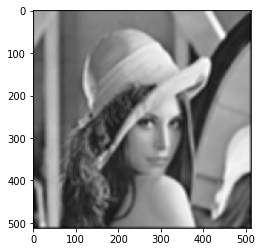

In [77]:
from scipy import ndimage
filter_matrix = np.ones((10,10))/100
img_filtered = ndimage.convolve(img_g_float, filter_matrix, mode='constant', cval=0.0) # in Matlab: imfilter
plt.imshow(img_filtered)

### Linear Filters - II: Edge Detection

#### By Hand, ...

In [78]:
np.max(img_g)

239

In [79]:
img_g_float.dtype

dtype('float64')

[[462 616 615 612 609]
 [  2   0  -3  -4  -3]
 [  3   3   1   0   0]
 [  5   3  -2  -3   0]
 [  0  -2  -4  -2   2]
 [ -9 -11  -9  -7  -6]]
[[206 104 103 100  97]
 [  2   0 253 252 253]
 [  3   3   1   0   0]
 [  5   3 254 253   0]
 [  0 254 252 254   2]
 [247 245 247 249 250]]


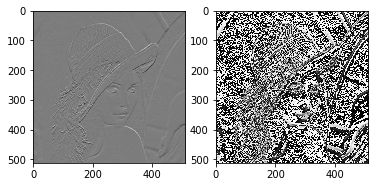

In [80]:
# since the last gray-image was in PIL-format, we first bring it back into
# array form
pil_g = np.array(pil_g)

Filter = np.array([[1, 0, -1],
                [2, 0, -2],
                [1, 0, -1]])

from scipy import ndimage

# WATCH OUT! The image type is important for the result!

img_filtered_int = ndimage.convolve(np.int16(img_g), Filter.T, mode='constant', cval=0.0)
img_filtered_uint8 = ndimage.convolve(img_g, Filter.T, mode='constant', cval=0.0)
#print(np.uint8(img_g)[:5, :5])
print(img_filtered_int[:6, :5])
print(img_filtered_uint8[:6, :5])

'''
# If you want to handle negative numbers and overflows here, you have to do it by hand:
img_filtered_int[img_filtered_int<0] = 0
img_filtered_int[img_filtered_int>255] = 255
img_filtered_uint8 = np.uint8(img_filtered_int)
'''

fig, axs = plt.subplots(1,2)
axs[0].imshow(img_filtered_int)
axs[1].imshow(img_filtered_uint8)

In the example above you see that you have to **really** watch out when working with *unsigned integers*, since filtered uint8-images tend to include values *>255* and *<0*.

Note that different functions handle the edge-areas different, but deliver the same results for the rest of the image, for example:

[[153 460 616 618 616]
 [154 462 616 615 612]
 [  1   2   0  -3  -4]
 [  1   3   3   1   0]
 [  2   5   3  -2  -3]
 [  0   0  -2  -4  -2]]


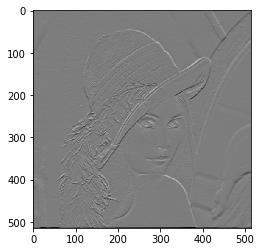

In [81]:
from scipy.signal import convolve2d
from scipy.ndimage import convolve

filtered = convolve2d(img_g, Filter.T)
filtered_b = convolve(img_g, Filter.T)
print(filtered[:6, :5])
plt.imshow(filtered)
#plt.imshow(filtered_b)

#### ... or with scikit-image ...

This is a Python package dedicated to image processing.

http://scikit-image.org/

Note that scikit-image does not have an own 2d linear filter, since this already exists in scipy (see also http://stackoverflow.com/questions/23208232/image-filtering-with-scikit-image)

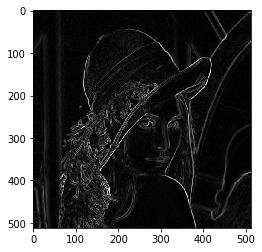

In [82]:
from skimage import filters
filtered = filters.sobel(img_g)
plt.imshow(filtered)

#### ... or with openCV

[[ -0.  -0.  -0.  -0.  -0.]
 [  2.  -0.  -3.  -4.  -3.]
 [  4.   3.   1.  -0.  -0.]
 [  6.   3.  -2.  -3.  -0.]
 [ -0.  -2.  -4.  -2.   2.]
 [-12. -11.  -9.  -7.  -6.]]


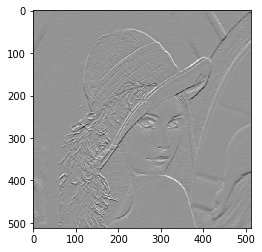

In [83]:
import cv2
filtered = -cv2.filter2D((img_g), cv2.CV_32F, Filter.T)            
plt.imshow(filtered)
print(filtered[:6, :5])

### Nonlinear Filters & Speed Comparison

In the following, I compare "closing" functions from three different packages. "Closing" is a morphological operation, where you first "dilate" and then "erode" and image with a "structuring element". It can be used e.g. to eliminate the eyelids in the image. For more information on morphological operations, see e.g. https://en.wikipedia.org/wiki/Mathematical_morphology.

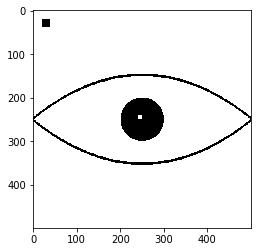

In [84]:
from scipy.ndimage.morphology import binary_closing
from skimage.morphology import closing, square

# To keep things simple, let us first generate a binary image
data = plt.imread(outFile)
bw = data[:,:,0]>0.5
bw_uint8 = np.uint8(bw*255)
plt.imshow(bw_uint8)

# Use a square with side-length 20 as "sturctural element"
strel = square(20)

In [85]:
print('Scikit Image:')
%timeit out = closing(bw, strel)

print('Scipy:')
%timeit out = binary_closing(bw, strel)

try:
    import cv2
    print('OpenCV:')
    %timeit out = cv2.morphologyEx(bw_uint8, cv2.MORPH_CLOSE, strel)
except ImportError:
    print('Sorry, could not run OpenCV!')

Scikit Image:
529 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Scipy:
94 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
OpenCV:
486 µs ± 6.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


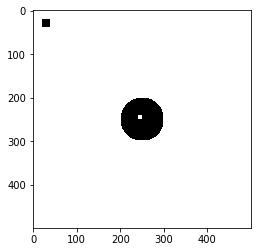

In [87]:
# Just to show you what it looks like:
out = closing(bw_uint8, strel)
plt.imshow(out)

<img src="data\images\Forward.png" align='left'> [5_ImgProc_Example_skimage](5_ImgProc_Example_skimage.ipynb)

<img src="data/images/CCA_40.png">
*Image Processing*  is licensed under a Creative Commons Attribution 4.0 International License.